In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import gfile
import imageio
import pickle
import scipy.misc
import sys
from IPython.display import HTML
import imageio
%matplotlib inline

In [2]:
def transform(image, resize_height=48, resize_width=48):
    cropped_image = scipy.misc.imresize(image, [resize_height, resize_width])
    return np.array(cropped_image)/127.5 - 1.
def inverse_transform(images):
    return (images+1.)/2.

In [ ]:
videos = gfile.Glob("/home/andrewliu/research/viewpoint/rllab/data/reach_distract/*.mp4")
# videos = pickle.load(open('videolist.pkl', 'rb'))
idata = [[] for _ in range(25)]
nfail = 0
idim = (48, 48)
itr = 0
np.random.shuffle(videos)
for name in videos:
    try:
        vid = imageio.get_reader(name,  'ffmpeg')
        if itr % 100 == 0:
            print(itr, map(len, idata))
        if itr % 1000 == 0:
            vdata = np.array(idata)
            np.save('vdata_reach_distract'+str(itr), vdata)
        if len(vid) == 51:
            frames = []
            for j in range(1, 51, 2):
                frame = transform(vid.get_data(j))
                if np.max(frame) == -1:
                    print("rip", itr, name)
                    frames = []
                    break
                frames.append(frame)
            if len(frames) != 25:
                continue
            for j, f in enumerate(frames):
                idata[j].append(f)
        else:
            print(name, len(vid))
        itr += 1
    except:
        nfail += 1
        print("Unexpected error:", sys.exc_info())
        print(name)
        if nfail > 10:
            break
vdata = np.array(idata)
np.save('vdata_reach_distract'+str(itr), vdata)
vdata.shape

0 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Unexpected error: (<type 'exceptions.KeyboardInterrupt'>, KeyboardInterrupt(), <traceback object at 0x7f9276a76d88>)
/home/andrewliu/research/viewpoint/rllab/data/reach_distract/openaigym.video.6011.29632.video000000.mp4
Unexpected error: (<type 'exceptions.KeyboardInterrupt'>, KeyboardInterrupt(), <traceback object at 0x7f9276a78290>)
/home/andrewliu/research/viewpoint/rllab/data/reach_distract/openaigym.video.1869.29632.video000000.mp4
Unexpected error: (<type 'exceptions.KeyboardInterrupt'>, KeyboardInterrupt(), <traceback object at 0x7f9276a78368>)
/home/andrewliu/research/viewpoint/rllab/data/reach_distract/openaigym.video.1471.29632.video000000.mp4
Unexpected error: (<type 'exceptions.KeyboardInterrupt'>, KeyboardInterrupt(), <traceback object at 0x7f9276a78488>)
/home/andrewliu/research/viewpoint/rllab/data/reach_distract/openaigym.video.6859.29632.video000000.mp4
Unexpected error: (<type 'exceptions.K

In [3]:
vdata = np.load('vdata_reach_distract3594.npy')
vdata.shape

(25, 3594, 48, 48, 3)

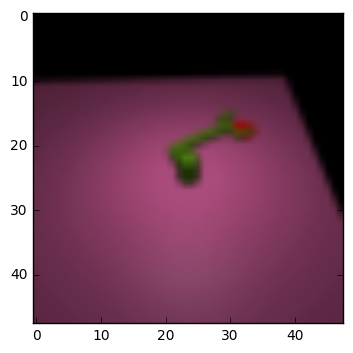

In [4]:
plt.imshow(inverse_transform(vdata[8][4]))

In [5]:
vdata.shape

(25, 3594, 48, 48, 3)

In [6]:
def lrelu(x, leak=0.2, name="lrelu"):
    return tf.maximum(x, leak*x)

def conv2d(input_, output_dim, 
       k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02,
       name="conv2d"):
    with tf.variable_scope(name):
        w = tf.get_variable('w', [k_h, k_w, input_.get_shape()[-1], output_dim],
                  initializer=tf.truncated_normal_initializer(stddev=stddev))
        conv = tf.nn.conv2d(input_, w, strides=[1, d_h, d_w, 1], padding='SAME')

        biases = tf.get_variable('biases', [output_dim], initializer=tf.constant_initializer(0.0))
        conv = tf.reshape(tf.nn.bias_add(conv, biases), conv.get_shape())

    return conv
class batch_norm(object):
    def __init__(self, epsilon=1e-5, momentum = 0.9, name="batch_norm"):
        with tf.variable_scope(name):
            self.epsilon  = epsilon
            self.momentum = momentum
            self.name = name

    def __call__(self, x):
        return tf.contrib.layers.batch_norm(x,
                      decay=self.momentum, 
                      updates_collections=None,
                      epsilon=self.epsilon,
                      scale=True,
                      is_training=tftrain,
                      scope=self.name)
def linear(input_, output_size, scope=None, stddev=0.02, bias_start=0.0, with_w=False):
    shape = input_.get_shape().as_list()

    with tf.variable_scope(scope or "Linear"):
        matrix = tf.get_variable("Matrix", [shape[1], output_size], tf.float32,
                 tf.random_normal_initializer(stddev=stddev))
        bias = tf.get_variable("bias", [output_size],
              initializer=tf.constant_initializer(bias_start))
    if with_w:
        return tf.matmul(input_, matrix) + bias, matrix, bias
    else:
        return tf.matmul(input_, matrix) + bias
    

def deconv2d(input_, output_shape,
       k_h=5, k_w=5, d_h=2, d_w=2, stddev=0.02,
       name="deconv2d", with_w=False):
    with tf.variable_scope(name):
        # filter : [height, width, output_channels, in_channels]
        w = tf.get_variable('w', [k_h, k_w, output_shape[-1], input_.get_shape()[-1]],
                  initializer=tf.random_normal_initializer(stddev=stddev))

        try:
            deconv = tf.nn.conv2d_transpose(input_, w, output_shape=output_shape,
                    strides=[1, d_h, d_w, 1])

        # Support for verisons of TensorFlow before 0.7.0
        except AttributeError:
            deconv = tf.nn.deconv2d(input_, w, output_shape=output_shape,
                    strides=[1, d_h, d_w, 1])

        biases = tf.get_variable('biases', [output_shape[-1]], initializer=tf.constant_initializer(0.0))
        deconv = tf.reshape(tf.nn.bias_add(deconv, biases), deconv.get_shape())

        if with_w:
            return deconv, w, biases
        else:
            return deconv

In [7]:
class ContextAE:
    def __init__(self, gf_dim=64, df_dim=64,
                 gfc_dim=1024, dfc_dim=1024,
                 c_dim=3):
        self.gf_dim = gf_dim
        self.df_dim = df_dim
        self.c_dim = c_dim

        self.gfc_dim = gfc_dim
        self.dfc_dim = dfc_dim


    def build(self, image):
        imgshape = image.get_shape().as_list()
        print(imgshape)
        self.output_height, self.output_width = imgshape[-3:-1]
        self.batch_size = imgshape[1]
        featsize = 1024
        srcimg = image[0]
        tgtimg = image[2]
        tgtctx = image[1]
        
        with tf.variable_scope("conv_context") as scope:
            tgtctx_h0 = lrelu(conv2d(tgtctx, self.df_dim, name='h0_conv'))
            tgtctx_h1 = lrelu(conv2d(tgtctx_h0, self.df_dim*2, name='h1_conv'))
            tgtctx_h2 = lrelu(conv2d(tgtctx_h1, self.df_dim*4, name='h2_conv'))
            tgtctx_h3 = lrelu(conv2d(tgtctx_h2, self.df_dim*8, name='h3_conv'))
            tgtctx_h4 = lrelu(linear(tf.reshape(tgtctx_h3, [self.batch_size, -1]), featsize, 'h4_lin'))
            tgtctx_z = linear(tgtctx_h4, featsize, 'hz_lin')

        with tf.variable_scope("conv") as scope:
            srcimg_h0 = lrelu(conv2d(srcimg, self.df_dim, name='h0_conv'))
            srcimg_h1 = lrelu(conv2d(srcimg_h0, self.df_dim*2, name='h1_conv'))
            srcimg_h2 = lrelu(conv2d(srcimg_h1, self.df_dim*4, name='h2_conv'))
            srcimg_h3 = lrelu(conv2d(srcimg_h2, self.df_dim*8, name='h3_conv'))
            print(srcimg_h3.get_shape())
            srcimg_h4 = lrelu(linear(tf.reshape(srcimg_h3, [self.batch_size, -1]), featsize, 'h4_lin'))
            srcimg_z = lrelu(linear(srcimg_h4, featsize, 'hz_lin'))
            
            scope.reuse_variables()
            
            tgtimg_h0 = lrelu(conv2d(tgtimg, self.df_dim, name='h0_conv'))
            tgtimg_h1 = lrelu(conv2d(tgtimg_h0, self.df_dim*2, name='h1_conv'))
            tgtimg_h2 = lrelu(conv2d(tgtimg_h1, self.df_dim*4, name='h2_conv'))
            tgtimg_h3 = lrelu(conv2d(tgtimg_h2, self.df_dim*8, name='h3_conv'))
            tgtimg_h4 = lrelu(linear(tf.reshape(tgtimg_h3, [self.batch_size, -1]), featsize, 'h4_lin'))
            tgtimg_z = lrelu(linear(tgtimg_h4, featsize, 'hz_lin'))

        with tf.variable_scope("translate") as scope:
            trans_h0 = lrelu(linear(tf.concat([srcimg_z, tgtctx_z], 1), featsize, 'trans_h0'))
            trans_z = linear(trans_h0, featsize, 'trans_z')
            self.translated_z = trans_z
        
        with tf.variable_scope("deconv") as scope:
            s_h, s_w = self.output_height, self.output_width
            s_h2, s_h4, s_h8, s_h16 = \
                int(s_h/2), int(s_h/4), int(s_h/8), int(s_h/16)
            s_w2, s_w4, s_w8, s_w16 = \
                int(s_w/2), int(s_w/4), int(s_w/8), int(s_w/16)

            output_z_ = lrelu(linear(trans_z, self.gf_dim*8*s_h16*s_w16, 'd_h0_lin'))
            output_h0 = tf.reshape(output_z_, [-1, s_h16, s_w16, self.gf_dim * 8])
            output_h1 = lrelu(deconv2d(tf.concat([output_h0, tgtctx_h3], 3),
                    [self.batch_size, s_h8, s_w8, self.gf_dim*4], name='d_h1'))
            output_h2 = lrelu(deconv2d(tf.concat([output_h1, tgtctx_h2], 3),
                [self.batch_size, s_h4, s_w4, self.gf_dim*2], name='d_h2'))
            output_h3 = lrelu(deconv2d(tf.concat([output_h2, tgtctx_h1], 3),
                [self.batch_size, s_h2, s_w2, self.gf_dim*1], name='d_h3'))
            output_h4 = deconv2d(tf.concat([output_h3, tgtctx_h0], 3),
                [self.batch_size, s_h, s_w, self.c_dim], name='d_h4')
            
            scope.reuse_variables()
            
            truthoutput_z_ = lrelu(linear(tgtimg_z, self.gf_dim*8*s_h16*s_w16, 'd_h0_lin'))
            truthoutput_h0 = tf.reshape(truthoutput_z_, [-1, s_h16, s_w16, self.gf_dim * 8])
            truthoutput_h1 = lrelu(deconv2d(tf.concat([truthoutput_h0, tgtctx_h3], 3),
                    [self.batch_size, s_h8, s_w8, self.gf_dim*4], name='d_h1'))
            truthoutput_h2 = lrelu(deconv2d(tf.concat([truthoutput_h1, tgtctx_h2], 3),
                [self.batch_size, s_h4, s_w4, self.gf_dim*2], name='d_h2'))
            truthoutput_h3 = lrelu(deconv2d(tf.concat([truthoutput_h2, tgtctx_h1], 3),
                [self.batch_size, s_h2, s_w2, self.gf_dim*1], name='d_h3'))
            truthoutput_h4 = deconv2d(tf.concat([truthoutput_h3, tgtctx_h0], 3),
                [self.batch_size, s_h, s_w, self.c_dim], name='d_h4')

        self.simloss = tf.reduce_mean((trans_z - tgtimg_z) ** 2) * 1e3
        mean, var = tf.nn.moments(tgtimg_z, axes=[0])
        print(var.get_shape())
#         self.simloss /= tf.reduce_mean(var)
        print(tgtimg_z.get_shape())
        self.out = output_h4# + contextimg#tf.nn.tanh(h4)
        self.out2 = truthoutput_h4
        self.recon1 = tf.nn.l2_loss(tgtimg - self.out)
        self.recon2 = tf.nn.l2_loss(tgtimg - self.out2)
        self.loss = self.recon1 + self.recon2 + self.simloss

In [8]:
tf.reset_default_graph()
idim = (48, 48)
tftrain = tf.placeholder(tf.bool, name='tftrain')
batch_size=100
tfinput = tf.placeholder(tf.float32, (3, batch_size) + idim + (3, ), name='x')
test = ContextAE()
test.build(tfinput)

[3, 100, 48, 48, 3]
(100, 3, 3, 512)
(1024,)
(100, 1024)


In [9]:
config = tf.ConfigProto(
#     device_count = {'GPU': 0}
                       )
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
learning_rate = tf.placeholder(tf.float32, shape=[])
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(test.loss)
sess.run(tf.global_variables_initializer())
allloss = []
validloss = []
itr = 0
saver = tf.train.Saver()

In [10]:
# new_saver = tf.train.import_meta_graph('viewpoint1000-DSG4239.meta')
# new_saver.restore(sess, 'viewpoint1000-DSG4239')

In [10]:
# saver.restore(sess, './ctxskipstartgoalvpdistract46349')
saver.restore(sess, './reachvpdistract130723')

INFO:tensorflow:Restoring parameters from ./reachvpdistract130723


In [19]:
saver.save(sess, 'reachvpdistract'+str(itr))

'reachvpdistract130723'

In [10]:
np.sum(np.max(np.max(np.max(vdata, axis=-1), axis=-1), axis=-1)==-1)

0

In [11]:
print(vdata.shape)
n = vdata.shape[1]
ntrain = 3000
nvalid = n - ntrain
print(ntrain, nvalid)
validdata = vdata[:, ntrain:]
traindata = vdata[:, :ntrain]
print(validdata.shape, traindata.shape)
while True:
    choicesrc = np.random.choice(ntrain, batch_size)
    choicetgt = np.random.choice(ntrain, batch_size)
    srcdata = traindata[np.arange(0, batch_size) % 25, choicesrc]
    tgtdata = traindata[np.arange(0, batch_size) % 25, choicetgt]
    tgtctx = traindata[0, choicetgt]
    batch = [srcdata, tgtctx, tgtdata]
    
#     print(sess.run( [test.recon1, test.recon2, test.loss, test.simloss], {tfinput: batch, learning_rate:1e-4, tftrain:False}))
    _, loss, sim, r1, r2 = sess.run( [optimizer, test.loss, test.simloss, test.recon1, test.recon2], {tfinput: batch, learning_rate:1e-4, tftrain:False})
    if itr % 4 == 0:
        print(loss, sim, r1, r2)
        allloss.append(loss)
    
    if itr % 40 == 0:
        choicesrc = np.random.choice(nvalid, batch_size)
        choicetgt = np.random.choice(nvalid, batch_size)
        srcdata = validdata[np.arange(0, batch_size) % 25, choicesrc]
        tgtdata = validdata[np.arange(0, batch_size) % 25, choicetgt]
        tgtctx = validdata[0, choicetgt]
        batch = [srcdata, tgtctx, tgtdata]
        loss, sim, r1, r2 = sess.run([test.loss, test.simloss, test.recon1, test.recon2], {tfinput: batch, tftrain:False})
        print(loss, sim, r1, r2,'E')
        validloss.append(loss)
    itr += 1

(25, 3594, 48, 48, 3)
3000 594
(25, 594, 48, 48, 3) (25, 3000, 48, 48, 3)
151.994 2.41674 114.768 34.8089
837.907 3.09951 555.28 279.527 E
116.769 2.28993 82.0533 32.4259


KeyboardInterrupt: 

In [14]:
nvalid

520

In [14]:
np.save('reachdata_valid', validdata)
np.save('reachdata_train', traindata[:, :200])

300.766 174.621 124.209


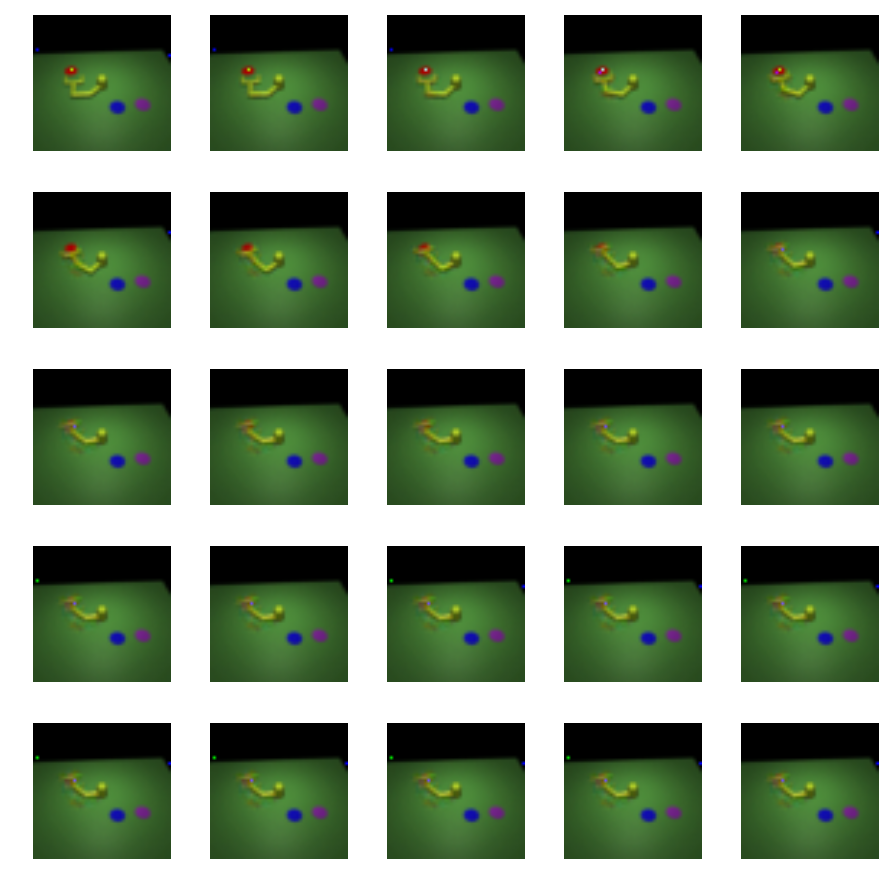

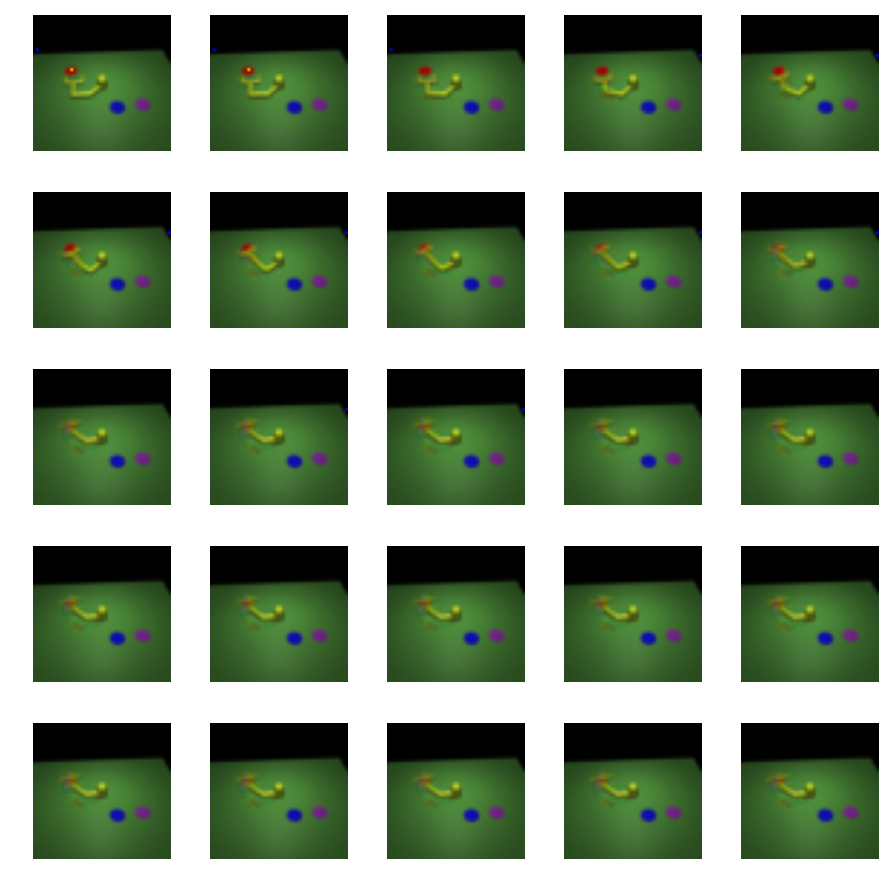

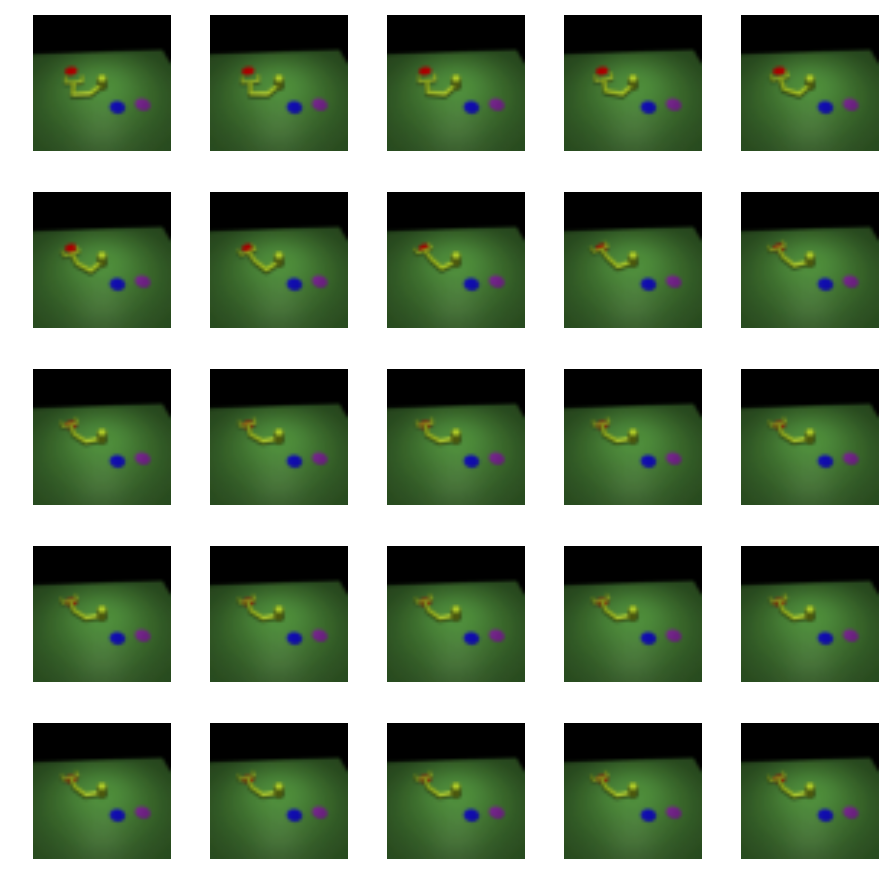

In [12]:
choicesrc = [2] * batch_size
choicetgt = [24] * batch_size
srcdata = validdata[np.arange(0, batch_size) % 25, choicesrc]
tgtdata = validdata[np.arange(0, batch_size) % 25, choicetgt]
tgtctx = validdata[0, choicetgt]
batch = [srcdata, tgtctx, tgtdata]

L, r1, r2, testouts= sess.run([test.loss, test.recon1, test.recon2, test.out], {tfinput: batch, tftrain: False})


L, r1, r2, testouts2= sess.run([test.loss, test.recon1, test.recon2, test.out2], {tfinput: batch, tftrain: False})


print(L, r1, r2)

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(9,9))
for i in range(25):
    axx = ax[i//5][i%5]
    axx.imshow(inverse_transform(testouts2[i]))
    axx.axis('off')
plt.tight_layout()


fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(9,9))
for i in range(25):
    axx = ax[i//5][i%5]
    axx.imshow(inverse_transform(testouts[i]))
    axx.axis('off')
plt.tight_layout()

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(9,9))
for i in range(25):
    axx = ax[i//5][i%5]
    axx.imshow(inverse_transform(tgtdata[i]))
    axx.axis('off')
plt.tight_layout()
# for k in range(25):
#     plt.figure()
#     plt.imshow(inverse_transform(tgtdata[k]))
#     plt.figure()
#     plt.imshow(inverse_transform(testouts[k]))

In [3]:
def savegif(name, frames):
    with imageio.get_writer(name, mode='I') as writer:
        for f in frames:
            writer.append_data((inverse_transform(f)*255).astype(np.uint8))
def disimgs(imgs):
    strs = ''
    for img in imgs:
        strs += '<img src="%s?rand=%f" width="200px"/><br/>'%(img, np.random.rand())
    return HTML(strs)

In [18]:
i1 = "gif/__outreach.gif"
i2 = "gif/__out2_reach.gif"
i3 = "gif/__truthreach.gif"
savegif(i1, testouts[:25])
savegif(i2, srcdata[:25])
savegif(i3, tgtdata[:25])
imgs =[i1, i2, i3]
disimgs(imgs)

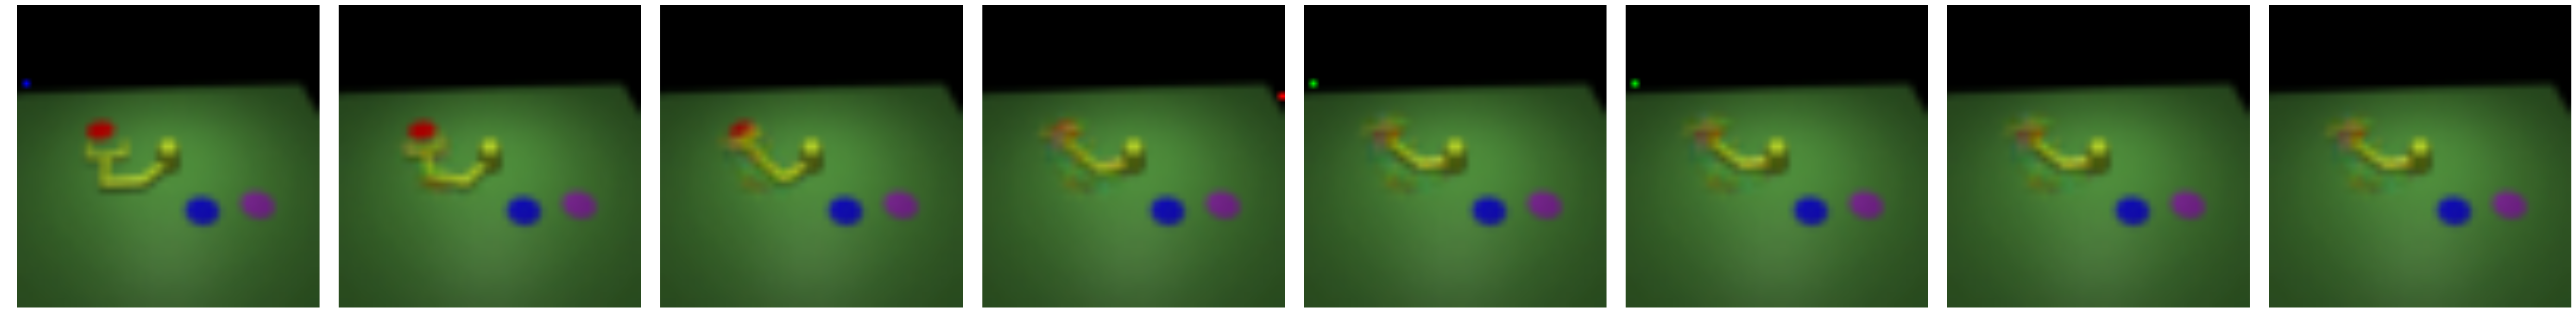

In [21]:
skip = 3
fig, ax = plt.subplots(nrows=1, ncols=25//skip, figsize=(50,10))
for i in range(25//skip):
    axx = ax[i]
    axx.imshow(inverse_transform(testouts[i*skip]))
    axx.axis('off')
plt.tight_layout()
# plt.subplots_adjust(left=-0.1, right=0.5, top=1, bottom=0)

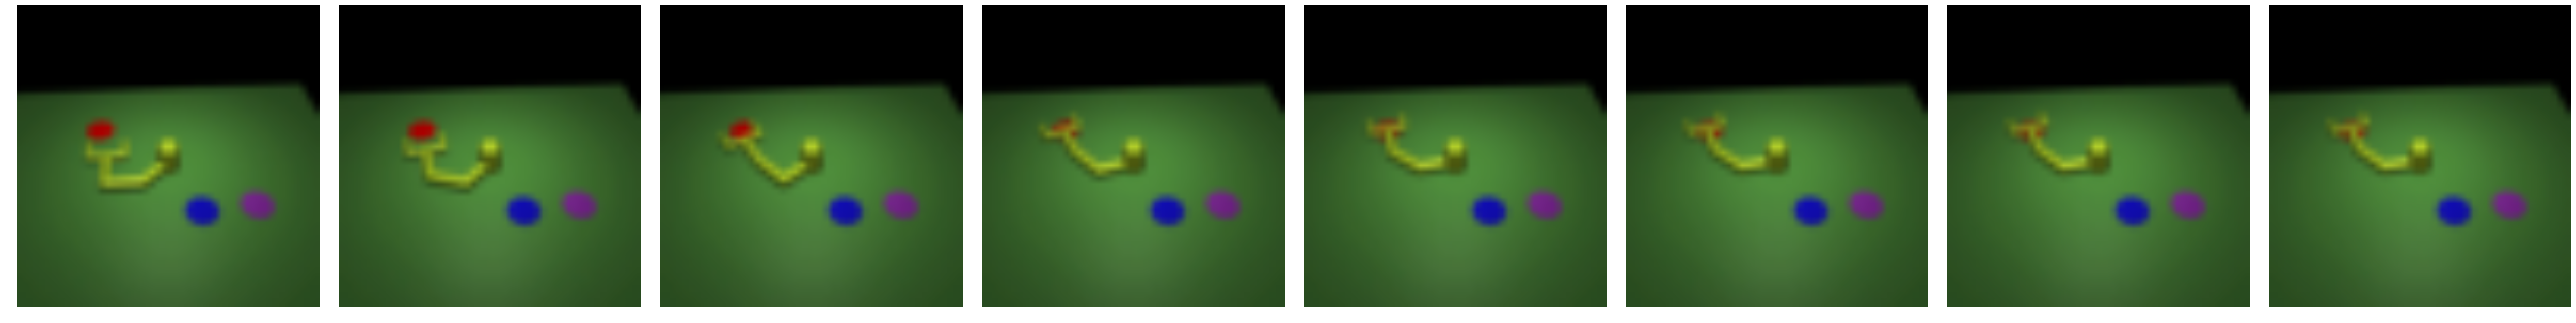

In [22]:
skip = 3
fig, ax = plt.subplots(nrows=1, ncols=25//skip, figsize=(50,10))
for i in range(25//skip):
    axx = ax[i]
    axx.imshow(inverse_transform(tgtdata[i*skip]))
    axx.axis('off')
plt.tight_layout()
# plt.subplots_adjust(left=-0.1, right=0.5, top=1, bottom=0)

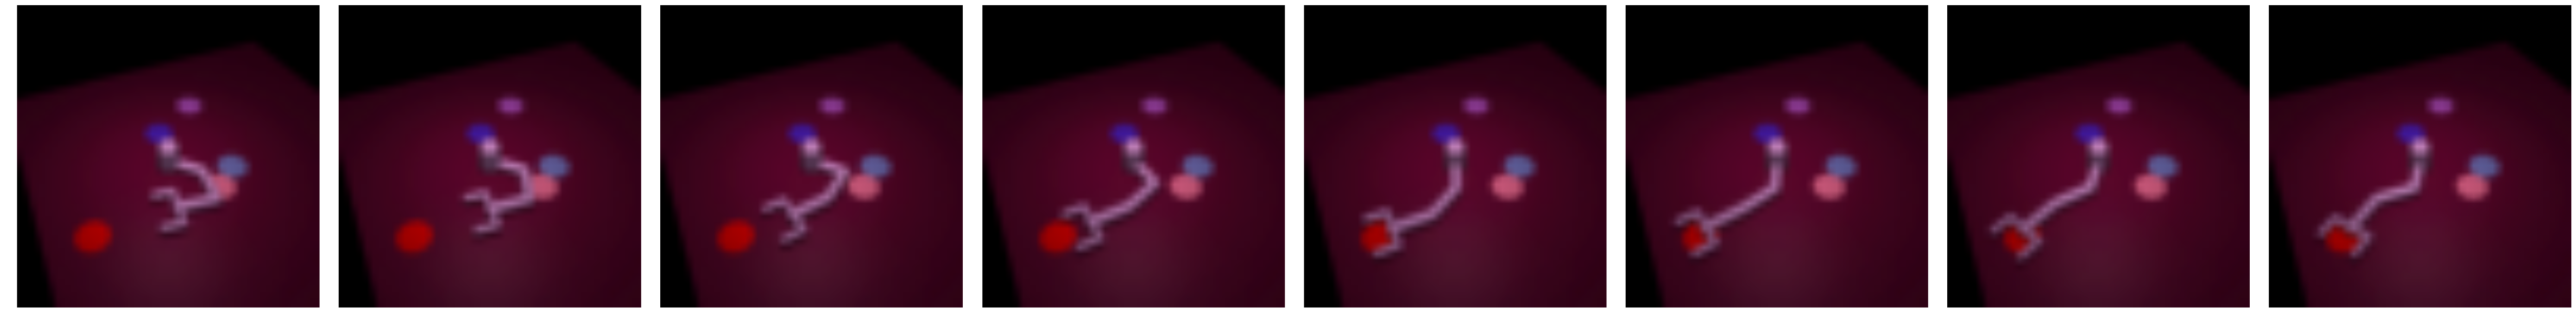

In [23]:
skip = 3
fig, ax = plt.subplots(nrows=1, ncols=25//skip, figsize=(50,10))
for i in range(25//skip):
    axx = ax[i]
    axx.imshow(inverse_transform(srcdata[i*skip]))
    axx.axis('off')
plt.tight_layout()
# plt.subplots_adjust(left=-0.1, right=0.5, top=1, bottom=0)

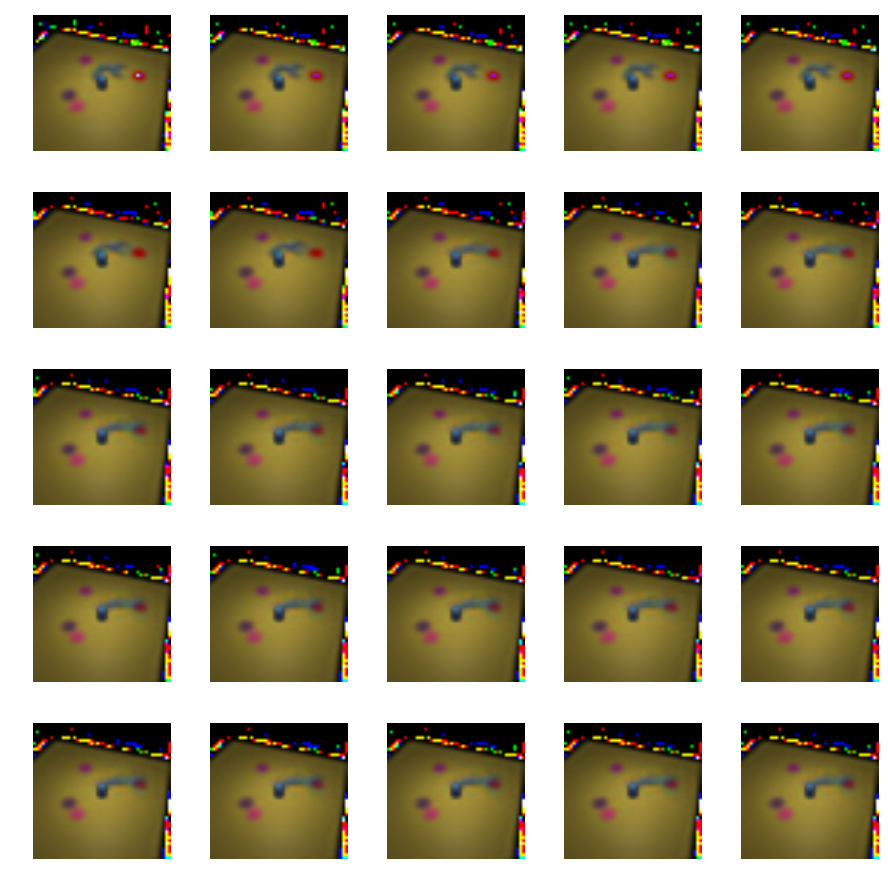

In [14]:
choicesrc = np.random.choice(ntrain, batch_size)
choicetgt = [8] * batch_size
srcdata = traindata[np.arange(0, batch_size) % 25, choicesrc]
tgtdata = traindata[np.arange(0, batch_size) % 25, choicetgt]
tgtctx = traindata[0, choicetgt]
batch = [srcdata, tgtctx, tgtdata]

testouts= sess.run(test.out, {tfinput: batch, tftrain: False})

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(9,9))
for i in range(25):
    axx = ax[i//5][i%5]
    axx.imshow(inverse_transform(testouts[i]))
    axx.axis('off')
plt.tight_layout()
# for k in range(25):
#     plt.figure()
#     plt.imshow(inverse_transform(tgtdata[k]))
#     plt.figure()
#     plt.imshow(inverse_transform(testouts[k]))

In [78]:
nvalid

4828

In [26]:
feats = []
for i in range(nvalid):
    if i % 100 == 0:
        print(i)
    choicesrc = [i] * batch_size
    choicetgt = [1] * batch_size
    srcdata = validdata[np.arange(0, batch_size) % 25, choicesrc]
    tgtdata = validdata[np.arange(0, batch_size) % 25, choicetgt]
    tgtctx = validdata[0, choicetgt]
    batch = [srcdata, tgtctx, tgtdata]
    feats.append(sess.run( test.translated_z, 
        {tftrain: False, tfinput: batch})[:25])

0
100
200
300
400
500


In [27]:
tffeats = np.array(feats)
tffeats.shape

(594, 25, 1024)

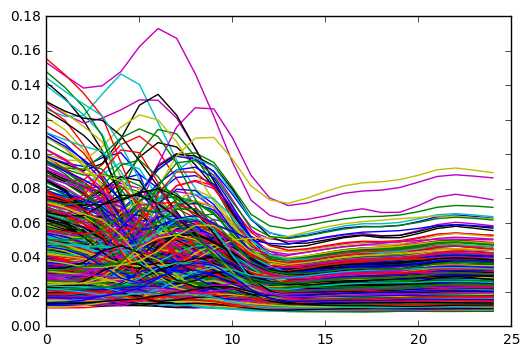

In [28]:
_=plt.plot(np.std(tffeats, axis=0))

In [29]:
means = np.mean(tffeats, axis=0)
means.shape

(25, 1024)

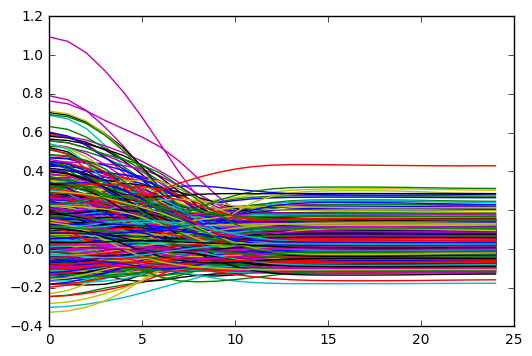

In [30]:
_=plt.plot(means)

In [84]:
np.save('ctxfeatsdistract250', means)

In [8]:
#name= '/home/andrewliu/research/viewpoint/rllab/data/local/trpo-push-res-translate/trpo_push_res_translate_2017_04_04_17_26_15_0001/gym_log/openaigym.video.0.26115.video004000.mp4'
name= '/home/andrewliu/research/viewpoint/rllab-push/data/s3/push-distract-comp/push_distract_comp_2017_05_08_19_04_08_0001/gym_log/openaigym.video.0.2796.video012000.mp4'
vid = imageio.get_reader(name,  'ffmpeg')
if len(vid) == 51:
    frames = []
    for j in range(1, 51, 2):
        frame = transform(vid.get_data(j))
        if np.max(frame) == -1:
            print("rip", itr, name)
            frames = []
            break
        frames.append(frame)
frames = np.array(frames)

In [9]:
i1 = "gif/pushvid.gif"
savegif(i1,frames)

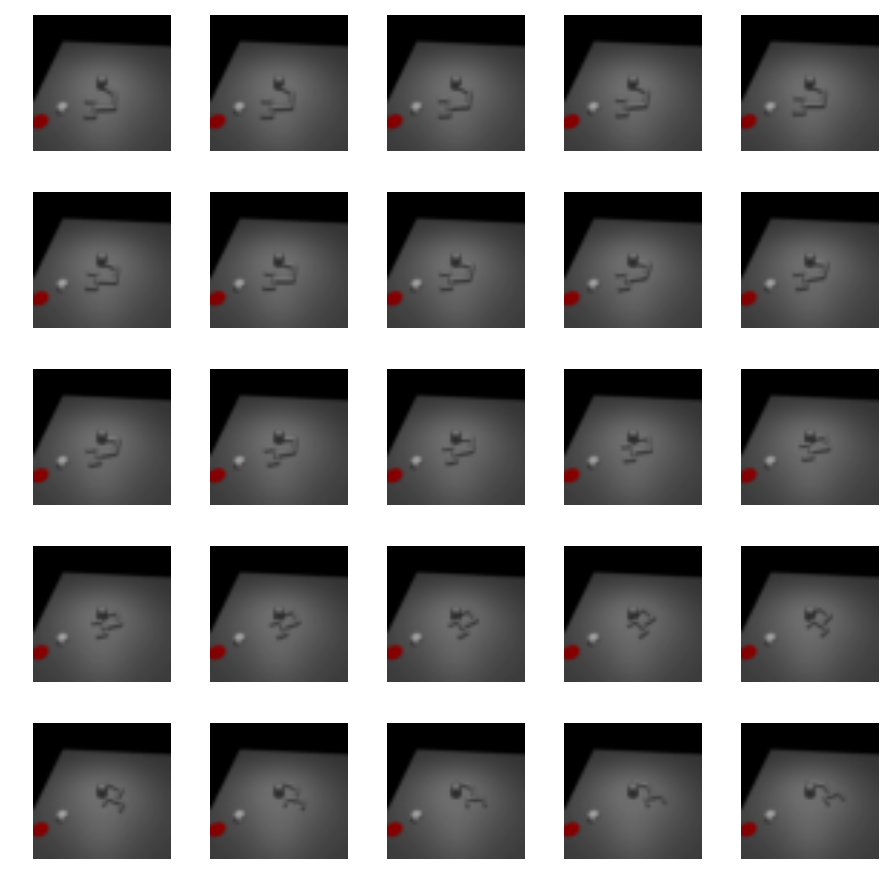

In [37]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(9,9))
for i in range(25):
    axx = ax[i//5][i%5]
    axx.imshow(inverse_transform(frames[i]))
    axx.axis('off')
plt.tight_layout()
# for k in range(25):
#     plt.figure()
#     plt.imshow(inverse_transform(tgtdata[k]))
#     plt.figure()
#     plt.imshow(inverse_transform(testouts[k]))

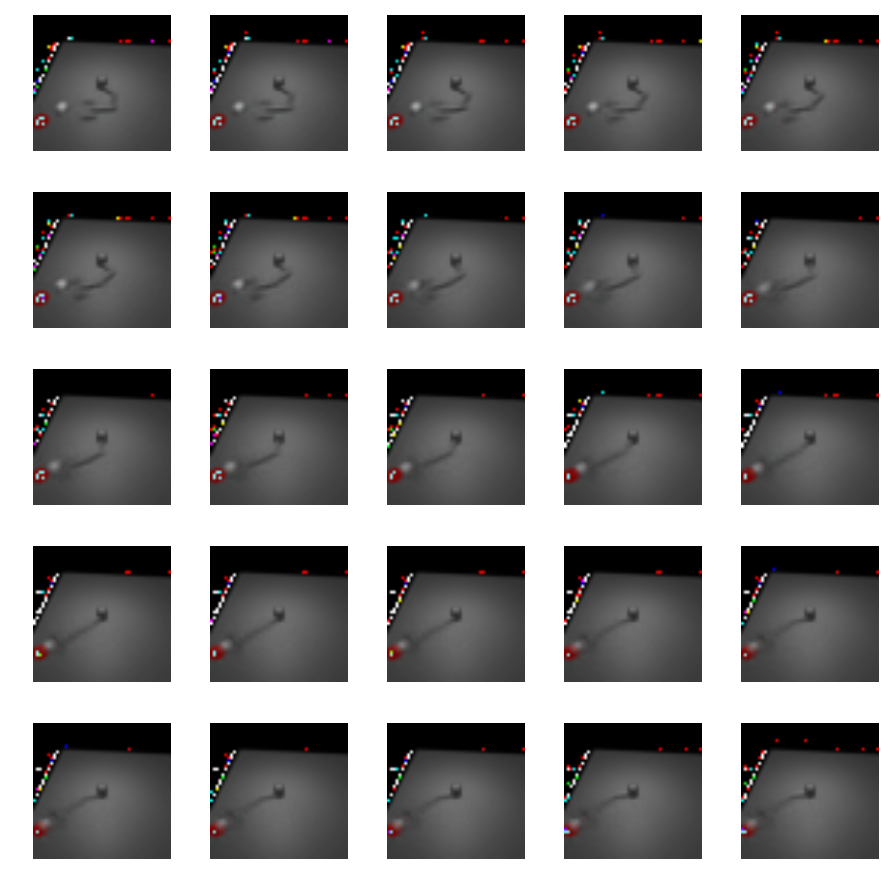

In [39]:
srcdata = frames[np.arange(0, batch_size) % 25]
tgtdata = srcdata
tgtctx = frames[[0] * batch_size]
batch = [srcdata, tgtctx, tgtdata]

testouts= sess.run(test.out, {tfinput: batch, tftrain: False})

fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(9,9))
for i in range(25):
    axx = ax[i//5][i%5]
    axx.imshow(inverse_transform(testouts[i]))
    axx.axis('off')
plt.tight_layout()
# for k in range(25):
#     plt.figure()
#     plt.imshow(inverse_transform(tgtdata[k]))
#     plt.figure()
#     plt.imshow(inverse_transform(testouts[k]))